In [1]:
import matplotlib.pyplot as plt
import os 
import cv2
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory 

2021-11-14 12:52:21.532820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 12:52:21.532839: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Image Prepocessing

In [2]:
DATA_DIR= './data/animals/'

seed = 111
val_split = 0.2
batch_s = 32
img_h = 256
img_w = 256

trn_data = image_dataset_from_directory(
    DATA_DIR,
    seed=seed,
    validation_split=val_split,
    subset="training",
    image_size=(img_h, img_w),
    batch_size=batch_s
)

val_data = image_dataset_from_directory(
    DATA_DIR,
    seed=seed,
    validation_split=val_split,
    subset="validation",
    image_size=(img_h, img_w),
    batch_size=batch_s
)

classes = trn_data.class_names

Found 5400 files belonging to 90 classes.
Using 4320 files for training.


2021-11-14 12:52:22.992476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 12:52:22.993320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 12:52:22.993463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-14 12:52:22.993515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-14 12:52:22.993561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Found 5400 files belonging to 90 classes.
Using 1080 files for validation.


#### Caching data to increase performanceon model training

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

trn_data = trn_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
for image_batch, labels_batch in trn_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2021-11-14 12:52:23.256777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
(32,)


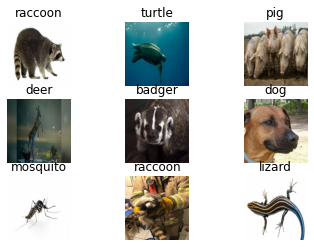

In [5]:
import matplotlib.pyplot as plt

for images, labels in trn_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

### Model training

In [6]:

model = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_h, img_w, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    Rescaling(1./255, input_shape=(img_h, img_w, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    layers.Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes))
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4

In [9]:
epochs=50
history = model.fit(
  trn_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/50
135/135 [==============================] - 118s 872ms/step - loss: 4.4345 - accuracy: 0.0255 - val_loss: 4.3785 - val_accuracy: 0.0296
Epoch 2/50
135/135 [==============================] - 126s 933ms/step - loss: 4.2472 - accuracy: 0.0468 - val_loss: 4.1563 - val_accuracy: 0.0676
Epoch 3/50
135/135 [==============================] - 127s 938ms/step - loss: 4.0208 - accuracy: 0.0769 - val_loss: 4.1379 - val_accuracy: 0.0694
Epoch 4/50
135/135 [==============================] - 130s 961ms/step - loss: 3.7417 - accuracy: 0.1248 - val_loss: 3.8457 - val_accuracy: 0.1204
Epoch 5/50
135/135 [==============================] - 130s 962ms/step - loss: 3.5089 - accuracy: 0.1759 - val_loss: 3.8490 - val_accuracy: 0.1407
Epoch 6/50
 13/135 [=>............................] - ETA: 1:41 - loss: 3.1377 - accuracy: 0.2163

KeyboardInterrupt: 

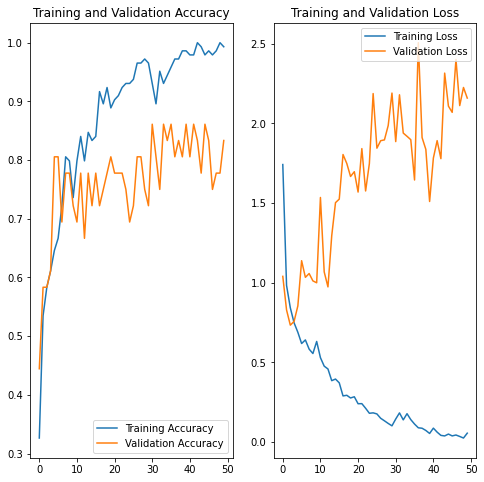

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
subjects
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Building the validation set